# Time Series Analysis and Forecasting with CNNs

Convolutional Neural Network models, or CNNs for short, can be applied to time series forecasting. I will be presenting different type of scenarios that we usually come across during solving problems related with time series and the variety of CNN architectures that we can use to tackle them.

Variety of time series related problems:
- CNN Models for Univariate time series
- CNN Models for Multivariate time series
- CNN Models for Multistep time series
- CNN Models for Multivariate and Multisteps time series


## Contents

- Imports
- Data Description
- Load and Prepare the Dataset
- Problem Framing
- Solution Approach
- Evaluation Metric 
- Train and Test sets
- Modeling and Evaluation
    - Univariate CNN Model
    - Multi-channel CNN Model
    - Multi-headed CNN  Model

## Imports

In [248]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

## Data Description

The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute. 

It is a multivariate series comprised of seven variables
(besides the date and time); they are:

- `global active power`: The total active power consumed by the household (kilowatts).
- `global reactive power`: The total reactive power consumed by the household (kilowatts).  voltage: Average voltage (volts).
- `global intensity`: Average current intensity (amps).
- `sub metering 1`: Active energy for kitchen (watt-hours of active energy).
- `sub metering 2`: Active energy for laundry (watt-hours of active energy).
- `sub metering 3`: Active energy for climate control systems (watt-hours of active energy).


## Problem Framing

> `Given some number of prior days of total daily power consumption, predict the next standard week of daily power consumption?`



## Solution Approach

Since we have to do some kind of prediction for whole week or for each day for next 7 days, this framing of the problem is referred to as a multi-step time series forecasting problem, given the multiple forecast steps.

A model that makes use of multiple input variables may be referred to as a multivariate multi-step time series forecasting model.

This framing of the dataset also suggests that it would be useful to downsample the per-minute observations of power consumption to daily totals.


## Evaluation Metric Selection

A forecast will be comprised of seven values, one for each day of the week ahead. It is common with multi-step forecasting problems to evaluate each forecasted time step separately. 

This is helpful for a few reasons:

- To comment on the skill at a specific lead time (e.g. +1 day vs +3 days).
- To contrast models based on their skills at different lead times (e.g. models good at +1 day vs models good at days +5).

The units of the total power are kilowatts and it would be useful to have an error metric that was also in the same units. Both Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) fit this bill, although RMSE is more commonly used.


## Train and Test Sets

We will use the first 3 years of data for training predictive models and the final year for evaluating models. 

The data in a given dataset will be divided into standard weeks. These are weeks that begin on a Sunday and end on a Saturday. This is a realistic and useful way for using the chosen framing of the model, where the power consumption for the week ahead can be predicted. 

It is also helpful with modeling, where models can be used to predict a specific day (e.g. Wednesday) or the entire sequence.


## Load and Prepare the Dataset

**Data Loading**

In [459]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip

--2024-01-28 14:12:17--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: 'individual+household+electric+power+consumption.zip'

tion.zip                [               <=>  ]   4.23M   284KB/s               ^C


In [ ]:
df = pd.read_csv('data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [ ]:
df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
df.shape

(2075259, 7)

In [ ]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

**Missing Values Imputation**

In [ ]:
df.isna().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

We have a lot of missing values in `Sub_metering_3` column. Before proceeding further we need to impute them with some reasonable values.


In [ ]:
df.replace('?', None, inplace=True)

Global_active_power      None
Global_reactive_power    None
Voltage                  None
Global_intensity         None
Sub_metering_1           None
Sub_metering_2           None
Sub_metering_3           None
dtype: object

In [ ]:
df['Sub_metering_3'].unique()

array([17., 16., 18.,  9.,  0.,  5., 19., 10., 20.,  8.,  4.,  2.,  3.,
       11., 13.,  6., 15., nan, 12.,  1., 14.,  7., 23., 25., 26., 28.,
       27., 21., 22., 29., 24., 30., 31.])

In [ ]:
df['Sub_metering_3'] = df[['Sub_metering_3']].fillna(method="ffill")
df['Sub_metering_3'] = df[['Sub_metering_3']].fillna(method="bfill")

In [ ]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Ok so now we don't have any null values. Let's check for the data type.

In [ ]:
df.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

**Datatype Conversion**

Most of the ML models expect data to be of `float32` type. 

In [ ]:
df = df.astype('float32')

In [ ]:
df.dtypes

Global_active_power      float32
Global_reactive_power    float32
Voltage                  float32
Global_intensity         float32
Sub_metering_1           float32
Sub_metering_2           float32
Sub_metering_3           float32
dtype: object

We are now done with data preparation part. We can move to do modeling.

**Downsampling data to day level**

In [51]:
# resample data to daily

daily_df = df.resample('D')

dataset = daily_df.sum()

dataset.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0


In [53]:
dataset.values

array([[1.20917603e+03, 3.49220009e+01, 9.35525312e+04, ...,
        0.00000000e+00, 5.46000000e+02, 4.92600000e+03],
       [3.39045996e+03, 2.26005997e+02, 3.45725312e+05, ...,
        2.03300000e+03, 4.18700000e+03, 1.33410000e+04],
       [2.20382593e+03, 1.61792007e+02, 3.47373625e+05, ...,
        1.06300000e+03, 2.62100000e+03, 1.40180000e+04],
       ...,
       [1.79624805e+03, 1.32460007e+02, 3.45644594e+05, ...,
        1.09600000e+03, 2.84800000e+03, 1.22240000e+04],
       [1.43116394e+03, 1.16127998e+02, 3.47812219e+05, ...,
        1.07600000e+03, 4.26000000e+02, 5.07200000e+03],
       [1.48810400e+03, 1.20826004e+02, 3.03487562e+05, ...,
        1.08000000e+03, 3.85000000e+02, 9.98900000e+03]], dtype=float32)

**Train and Test Split**

The final year of the data is in 2010 and the first Sunday for 2010 was January 3rd. The data ends in mid November 2010 and the closest final Saturday in the data is November 20th. This gives 46 weeks of test data.

The function split dataset() below splits the daily data into train and test sets and organizes each into standard weeks. Specific row offsets are used to split the data using knowledge of the dataset.

The split datasets are then organized into weekly data using the `NumPy` `split()` function.


In [76]:
from numpy import array, split

In [80]:
def split_dataset(data):
    #split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    train = torch.tensor(split(train, len(train)/7))
    test = torch.tensor(split(test, len(test)/7))

    return train, test

In [82]:

train, test = split_dataset(dataset.values)

# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

torch.Size([159, 7, 7])
tensor(3390.4600) tensor(1311.8060)
torch.Size([46, 7, 7])
tensor(2083.4541) tensor(2197.0061)


## Univariate CNN Model

In this section, we will develop a convolutional neural network for multi-step time series forecasting using only the univariate sequence of daily power consumption.

Basically here we want to answer:

> `Given some number of prior days of total daily power consumption, predict the next standard week of daily power consumption?`

**Time Series To Supervised Learning Data Preparation**

A `1D` CNN model expects data to have the shape of: `[samples, timesteps, features]`. One sample will be comprised of seven time steps with one feature for the seven days of total daily power consumed. The training dataset has 159 weeks of data, so the shape of the training dataset would be: `[159, 7, 1]`.

The training data is provided in standard weeks with eight variables, specifically in the shape `[159, 7, 8]`. The first step is to flatten the data so that we have eight time series sequences.

We then need to iterate over the time steps and divide the data into overlapping windows; each iteration moves along one time step and predicts the subsequent seven days. 

For example:

`Input, Output`

`[d01, d02, d03, d04, d05, d06, d07], [d08, d09, d10, d11, d12, d13, d14]`

`[d02, d03, d04, d05, d06, d07, d08], [d09, d10, d11, d12, d13, d14, d15] ...`

In [111]:
x = array([1, 2, 3, 4])
x.shape
split(x, 2)

[array([1, 2]), array([3, 4])]

In [112]:
def to_supervised(train, n_input, n_out=7):
    """
    
    input - a list of weeks (history) and the number of time steps to use as inputs outputs 
    returns - the data in the overlapping moving window format.
    
    """
    #flatten data
    data = train.reshape(train.shape[0]*train.shape[1], train.shape[2])
    X, y = [], []
    in_start = 0

    for _ in range(len(data)):

        #define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out

        #ensure we have all the data for that window
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.view((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return torch.tensor(X), torch.tensor(y)

    

In [123]:
X, y = to_supervised(train, 7, 7)
X.shape

torch.Size([1099, 7, 1])

When we run the above function on the entire training dataset, we transform `159` samples into `1,099`; specifically, the transformed dataset has the shapes `X=[1099, 7, 1]` and `y=[1099, 7]`.

In [120]:
train[0]

array([[3.3904600e+03, 2.2600600e+02, 3.4572531e+05, 1.4398600e+04,
        2.0330000e+03, 4.1870000e+03, 1.3341000e+04],
       [2.2038259e+03, 1.6179201e+02, 3.4737362e+05, 9.2472002e+03,
        1.0630000e+03, 2.6210000e+03, 1.4018000e+04],
       [1.6661940e+03, 1.5094200e+02, 3.4847900e+05, 7.0940000e+03,
        8.3900000e+02, 7.6020000e+03, 6.1970000e+03],
       [2.2257480e+03, 1.6099800e+02, 3.4892362e+05, 9.3130000e+03,
        0.0000000e+00, 2.6480000e+03, 1.4063000e+04],
       [1.7171121e+03, 1.4416600e+02, 3.4710088e+05, 7.2406001e+03,
        1.7650000e+03, 2.6230000e+03, 1.0421000e+04],
       [2.3413379e+03, 1.8690601e+02, 3.4730575e+05, 9.8970000e+03,
        3.1510000e+03, 3.5000000e+02, 1.1131000e+04],
       [4.7733862e+03, 2.2147000e+02, 3.4579594e+05, 2.0200400e+04,
        2.6690000e+03, 4.2500000e+02, 1.4726000e+04]], dtype=float32)

Next, we can define and fit the CNN model on the training data. This multi-step time series forecasting problem is an autoregression

**Model Architecture**

- convolution layer with 16 filters and kernel size = 3
- Relu activation function
- A pooling layer
- Flattening
- Linear layer with 10 nodes
- Relu activation function
- Linear layer with `n_out` nodes
- `MSE` as loss function
- Optimizer - `Adam`


In [168]:
#define model

class UnivariateCNNModel(nn.Module):

    def __init__(self, n_timestamp, n_features) -> None:
        super().__init__()
        self.conv_net = nn.Sequential(
                nn.Conv1d(in_channels=n_features, out_channels=16, kernel_size=3),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
            )
        self.flt_layer = nn.Flatten()
        self.ln_layer = nn.Sequential(
                nn.Linear(in_features=32, out_features=10), 
                nn.ReLU(), 
                nn.Linear(in_features=10, out_features=n_timestamp)
            )
    def forward(self, X):
        #X -> (B, T, C)
        B, T, C = X.shape
        X = X.view(B, C, T)
        X = self.conv_net(X)
        # print(X.shape)
        X = self.flt_layer(X)
        X = self.ln_layer(X)

        return X

#define variables
n_timestamp = 7
n_features = 1

model = UnivariateCNNModel(n_timestamp, n_features)


In [169]:
#check the output from untrained mode just for sanity check
model(X)

tensor([[ -88.9717,   -7.9742, -253.7858,  ...,    9.3355,  174.4473,
          -49.3912],
        [ -58.1965,  -61.4020, -247.2206,  ...,   45.9940,   78.5566,
          -46.1676],
        [ -44.2537,  -41.0751, -225.0095,  ...,   33.9901,   94.1954,
          -52.4452],
        ...,
        [ -98.6096,  -11.7230, -228.2829,  ...,   11.5513,  130.4908,
          -65.4323],
        [ -48.2699,    8.9337, -159.6686,  ...,   15.1565,  108.5201,
          -36.7259],
        [-112.3470,    9.1581, -229.3958,  ...,   20.7558,  136.7785,
          -46.3908]], grad_fn=<AddmmBackward0>)

**Define the optimizer and loss**

In [170]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = torch.nn.MSELoss()

In [171]:
#check loss for untrained model
y_pred = model(X)
criterion(y_pred, y)

tensor(2977705.7500, grad_fn=<MseLossBackward0>)

**Model's Training**



In [172]:

n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]

print(f"n_timesteps : {n_timesteps}, n_features : {n_features}, n_outputs : {n_outputs}")


n_timesteps : 7, n_features : 1, n_outputs : 7


**Training Loop**

2977705.75
2965815.5
2953951.25
2942164.75
2930417.5
2918724.75
2907119.0
2895588.25
2884119.75
2872727.25
2861421.0
2850182.5
2839007.25
2827873.0
2816739.5
2805646.0
2794545.5
2783444.75
2772320.5
2761181.75
2750000.25
2738749.5
2727419.25
2715972.75
2704384.5
2692636.0
2680690.75
2668549.25
2656195.75
2643591.0
2630704.75
2617522.0
2603997.25
2590070.25
2575726.5
2560923.75
2545606.25
2529744.0
2513264.5
2496127.75
2478281.75
2459632.25
2440153.25
2419811.25
2398541.75
2376347.25
2353208.75
2329074.5
2303975.5
2277922.25
2250898.0
2222897.75
2193913.0
2163932.0
2132949.5
2100957.75
2067946.625
2033946.0
1998937.0
1962917.625
1925897.375
1887916.5
1848983.0
1809121.5
1768341.875
1726718.75
1684257.625
1641018.25
1597070.25
1552476.75
1507299.25
1461580.625
1415377.0
1368796.0
1321985.25
1275028.125
1228048.75
1181188.375
1134563.0
1088318.5
1042561.9375
997463.625
953177.875
909842.25
867625.3125
826670.5625
787105.875
749079.1875
712694.9375
678069.4375
645253.375
614356.3125
585416

Text(0, 0.5, 'Training Loss')

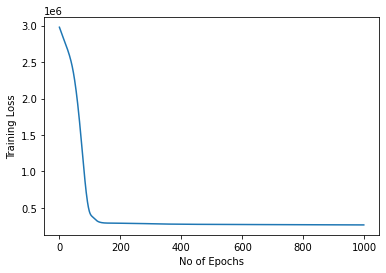

In [173]:
epochs = 1000

losses = []

for _ in range(epochs):

    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    print(loss.item())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

#plot the training losses

plt.plot(losses)
plt.xlabel("No of Epochs")
plt.ylabel("Training Loss")

## Model Evaluation

Models will be evaluated using a scheme called **walk-forward validation**. This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week.

This is both realistic for how the model may be used in practice and beneficial to the models, allowing them to make use of the best available data. 

For example:

`Input -> predict`

`[Week1] -> Week2`

`[Week1 + Week2]  -> Week3`

`[Week1 + Week2 + Week3]  ->  Week4`

`...`

In [175]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [177]:
def evaluate_forecasts(actual, predicted):
  
  scores = list()
  # calculate an RMSE score for each day
  for i in range(actual.shape[1]):
    # calculate mse
    mse = mean_squared_error(actual[:, i], predicted[:, i])
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)
  # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
  return score, scores

In [193]:
history = [x for x in train]

data = array(history)
print(data.shape)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
input_x = data[-7:, 0]
print(input_x)

(159, 7, 7)
[2195.452 2094.098 2047.968 2451.11  2211.892 1224.252 1311.806]


In [197]:
dataset.shape

(1442, 7)

In [210]:
X[-1]

model.forward(X[-1][None])[0]

tensor([2008.4426, 2112.8894, 2104.7432, 2032.2062, 2088.1284, 2155.6680,
        2071.2598], grad_fn=<SelectBackward0>)

In [220]:
train[-1][:, 0][None]

array([[2195.452, 2094.098, 2047.968, 2451.11 , 2211.892, 1224.252,
        1311.806]], dtype=float32)

In [223]:
test.shape

(46, 7, 7)

In [246]:
#evaluation 

#get the last train 
n_test = len(test)
n_input = 7

#extract the last 7 days training data from train
history = train[-1][:, 0]
#rehsape hist into (B, T, C)
B = 1
T = 7
C = 1

predictions = []

for i in range(n_test):
    n_in = 0
    # reshape the data from (B, T, C) -> (B, C, T)
    history = torch.tensor(history).view(B, T, C)
    # # reshape into [1, n_input, 1]
    with torch.no_grad():
        yhat = model.forward(history)
        # store the predictions
        predictions.append(yhat[0].tolist())
    history = test[i][n_in:n_in+n_input, 0]
    n_in += n_input
    
predictions = array(predictions)
score, scores = evaluate_forecasts(array(test[:, :, 0].tolist()), predictions)

    

cnn: [430.179] 492.5, 429.3, 349.1, 395.3, 425.0, 325.5, 551.1


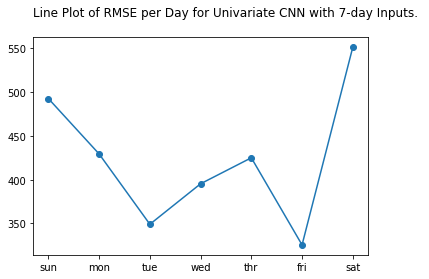

In [252]:
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
plt.plot(days, scores, marker='o', label='cnn') 
plt.title("Line Plot of RMSE per Day for Univariate CNN with 7-day Inputs. \n", loc='left')
plt.show()

This plot shows that perhaps Tuesdays and Fridays are easier days to forecast than the other days and that perhaps Saturday at the end of the standard week is the hardest day to forecast.

## Multi-channel CNN Model

In this section, we will update the CNN developed in the previous section to use each of the eight time series variables to predict the next standard week of daily total power consumption. We will do this by providing each one-dimensional time series to the model as a separate channel of input. The CNN will then use a separate kernel and read each input sequence onto a separate set of filter maps, essentially learning features from each input time series variable. This is helpful for those problems where the output sequence is some function of the observations at prior time steps from multiple different features, not just (or including) the feature being forecasted.

It is unclear whether this is the case in the power consumption problem, but we can explore it nonetheless. First, we must update the preparation of the training data to include all of the eight features, not just the one total daily power consumed. 

**change supervised data transform function**


In [260]:
def to_supervised(train, n_input, n_out=7):
    """
    
    input - a list of weeks (history) and the number of time steps to use as inputs outputs 
    returns - the data in the overlapping moving window format.
    
    """
    #flatten data
    data = train.reshape(train.shape[0]*train.shape[1], train.shape[2])
    X, y = [], []
    in_start = 0

    for _ in range(len(data)):

        #define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out

        #ensure we have all the data for that window
        if out_end < len(data):
            x_input = data[in_start:in_end, :]
            #x_input = x_input.view((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return torch.tensor(X), torch.tensor(y)

    

In [296]:
X, y = to_supervised(train, 14)
X.shape, y.shape

(torch.Size([1092, 14, 7]), torch.Size([1092, 7]))

We will use 14 days of prior observations across seven of the input variables.

In [297]:
n_input = 14

Finally, the model used in the previous section does not perform well on this new framing of the problem. The increase in the amount of data requires a larger and more sophisticated model that is trained for longer. 

**New Model Architecture**

Two convolutional layers with `32` filter maps followed by pooling, then another convolutional layer with `16` feature maps and pooling. The fully connected layer that interprets the features is increased to `100` nodes and final layer contains `n_out` nodes.


In [325]:
class MultiChannelCNNModel(nn.Module):

    def __init__(self, n_feature, n_out) -> None:
        super().__init__()
        #define convnets
        self.conv_layer1 = nn.Sequential(
            nn.Conv1d(in_channels=n_feature, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.flt_layer = nn.Flatten()
        self.ln_layer = nn.Sequential(
            nn.Linear(in_features=32, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=n_out)
        )

    def forward(self, X):

        #shape of X => (B, T, C) => (B, C, T)
        B, T, C = X.shape
        # print(B, T, C)
        X = X.view(B, C, T)
        X = self.conv_layer1(X)
        X = self.conv_layer2(X)
        X = self.flt_layer(X)
        X = self.ln_layer(X)

        return X
    
n_feature = 7
n_out = 7     
multi_channel_model = MultiChannelCNNModel(n_feature=n_feature, n_out=n_out)

In [326]:
multi_channel_model.parameters

<bound method Module.parameters of MultiChannelCNNModel(
  (conv_layer1): Sequential(
    (0): Conv1d(7, 32, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv1d(32, 16, kernel_size=(2,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flt_layer): Flatten(start_dim=1, end_dim=-1)
  (ln_layer): Sequential(
    (0): Linear(in_features=32, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=7, bias=True)
  )
)>

**Define optimizer and loss function**

In [327]:
optimizer = torch.optim.Adam(multi_channel_model.parameters(), lr=1e-3)

criterion = torch.nn.MSELoss()

**Models Training**

390870464.0
237132912.0
130711816.0
61832276.0
23469858.0
5587388.0
3823495.25
10836916.0
18979518.0
24608476.0
26469838.0
26073732.0
24360348.0
21469828.0
17906974.0
14261224.0
10877793.0
7866655.5
5328859.0
3331293.25
1994532.0
1294689.75
1166760.875
1464935.375
1958473.0
2409328.5
2755325.75
2931585.5
2935711.0
2793035.75
2536169.25
2202276.0
1829042.375
1453139.0
1109390.375
828338.625
631955.0625
528976.75
513120.84375
560076.125
631488.25
690232.25
718660.875
717517.1875
697101.4375
668838.375
639529.0625
610258.1875
578637.1875
542385.875
502159.96875
462073.71875
428080.125
405193.375
395398.125
396877.5625
404921.34375
414070.0
420248.34375
421961.46875
420100.5
416702.3125
413488.96875
410961.03125
408400.5625
404600.59375
398803.9375
391275.75
383255.78125
376368.4375
371863.4375
370089.0625
370460.125
371860.4375
373236.34375
374024.8125
374233.59375
374195.75
374207.25
374286.0625
374179.4375
373563.0
372285.3125
370493.875
368577.34375
366972.1875
365963.0625
365576.96875

Text(0, 0.5, 'Training Loss')

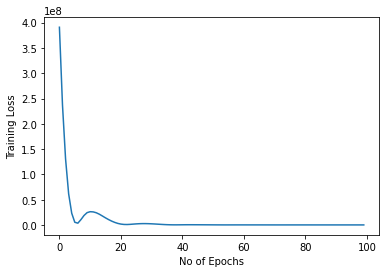

In [328]:
epochs = 100

losses = []

for _ in range(epochs):

    optimizer.zero_grad()
    y_pred = multi_channel_model(X)
    loss = criterion(y_pred, y)
    print(loss.item())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

#plot the training losses

plt.plot(losses)
plt.xlabel("No of Epochs")
plt.ylabel("Training Loss")

**Model Evaluation**

In [320]:
def evaluate_forecasts(actual, predicted):
  
  scores = list()
  # calculate an RMSE score for each day
  for i in range(actual.shape[1]):
    # calculate mse
    mse = mean_squared_error(actual[:, i], predicted[:, i])
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)
  # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
  return score, scores

In [324]:
train.shape

(159, 7, 7)

In [331]:
train[-2][:, :].shape

(7, 7)

In [329]:
#evaluation 

#get the last train 
n_test = len(test)
n_input = 14

#extract the last 7 days training data from train
history = train[-2][:, :].extend(train[-1][:, :])
#rehsape hist into (B, T, C)
B = 1
T = 14
C = 7

predictions = []

for i in range(n_test):
    n_in = 0
    # reshape the data from (B, T, C) -> (B, C, T)
    history = torch.tensor(history[-T]).view(B, T, C)
    # # reshape into [1, n_input, 1]
    with torch.no_grad():
        yhat = multi_channel_model.forward(history)
        # store the predictions
        predictions.append(yhat[0].tolist())
    history = history.extend(test[i][n_in:n_in+n_input, :])
    n_in += n_input
    
predictions = array(predictions)
score, scores = evaluate_forecasts(array(test[:, :, 0].tolist()), predictions)

    

AttributeError: 'numpy.ndarray' object has no attribute 'extend'

cnn: [485.897] 449.7, 544.5, 431.6, 508.7, 440.1, 397.2, 597.9


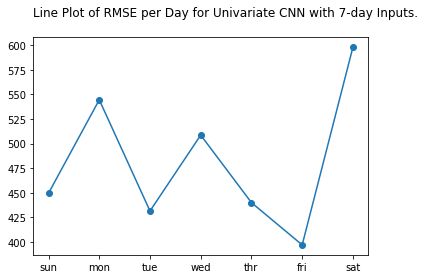

In [322]:
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
plt.plot(days, scores, marker='o', label='cnn') 
plt.title("Line Plot of RMSE per Day for Univariate CNN with 7-day Inputs. \n", loc='left')
plt.show()

## Multi-headed CNN Model

We can further extend the CNN model to have a separate sub-CNN model or head for each input variable, which we can refer to as a multi-headed CNN model.

This requires a modification to the preparation of the model, and in turn, modification to the preparation of the training and test datasets.

Starting with the model, we must define a separate CNN model for each of the eight input variables. The configuration of the model, including the number of layers and their hyperparameters, were also modified to better suit the new approach. 

We can loop over each variable and create a submodel that takes a one-dimensional sequence of 14 days of data and outputs a flat vector containing a summary of the learned features from the sequence. Each of these vectors can be merged via concatenation to make one very long vector that is then interpreted by some fully connected layers before a prediction is made.

As we build up the submodels, we keep track of the input layers and flatten layers in lists. This is so that we can specify the inputs in the definition of the model object and use the list of flatten layers in the merge layer.

In [333]:
import torch
import torch.nn as nn
import torch.optim as optimizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [334]:
def split_dataset(data):
  # split into standard weeks
  train, test = data[1:-328], data[-328:-6]
  # restructure into windows of weekly data
  train = array(split(train, len(train)/7))
  test = array(split(test, len(test)/7))
  return train, test


In [342]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
     X.append(data[in_start:in_end, :])
     y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)

In [345]:
# plot training history
def plot_history(history):
    # plot loss
    plt.subplot(2, 1, 1) 
    plt.plot(history.history['loss'], label='train') 
    plt.plot(history.history['val_loss'], label='test') 
    plt.title('loss', y=0, loc='center') 
    plt.legend()
    # plot rmse
    plt.subplot(2, 1, 2) 
    plt.plot(history.history['rmse'], label='train') 
    plt.plot(history.history['val_rmse'], label='test') 
    plt.title('rmse', y=0, loc='center') 
    plt.legend()
    plt.show()

In [347]:
train, test = split_dataset(dataset.values)

print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (159, 7, 7), Test shape: (46, 7, 7)


In [350]:
train_x, train_y = to_supervised(train, 14)

print(f"X : {train_x.shape}, Y : {train_y.shape}")

X : torch.Size([1092, 14, 7]), Y : torch.Size([1092, 7])


In [439]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming your data (train_x, train_y) is already loaded and preprocessed

class MultiHeadedCNN(nn.Module):
    def __init__(self, n_timesteps, n_features, n_outputs):
        super(MultiHeadedCNN, self).__init__()
        self.heads = nn.ModuleList([nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten()
        ) for _ in range(n_features)])

        self.dense1 = nn.Linear(32 * n_features, 200)
        self.dense2 = nn.Linear(200, 100)
        self.out = nn.Linear(100, n_outputs)

    def forward(self, x):
        outputs = [head(x[:, i, :].unsqueeze(1)) for i, head in enumerate(self.heads)]
        merged = torch.cat(outputs, dim=1)
        # print(merged.shape)
        out = torch.relu(self.dense1(merged))
        out = torch.relu(self.dense2(out))
        out = self.out(out)
        return out

# Model initialization
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
model = MultiHeadedCNN(n_timesteps, n_features, n_outputs)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [440]:
# evaluate model and get scores
n_input = 14

In [441]:
# Converting data to PyTorch tensors
train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)

/var/folders/xf/gcbfh98s6n53wh5f2hpb84nh0000gn/T/ipykernel_5929/1520043488.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
/var/folders/xf/gcbfh98s6n53wh5f2hpb84nh0000gn/T/ipykernel_5929/1520043488.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_tensor = torch.tensor(train_y, dtype=torch.float32)


In [442]:
train_x_tensor.shape

torch.Size([1092, 14, 7])

In [443]:
# Training loop
epochs = 1000
train_losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(train_x_tensor)
    loss = criterion(outputs, train_y_tensor)
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/1000], Loss: 11158590.0000
Epoch [6/1000], Loss: 933244.5000
Epoch [11/1000], Loss: 790186.8750
Epoch [16/1000], Loss: 433752.8125
Epoch [21/1000], Loss: 421936.4688
Epoch [26/1000], Loss: 419620.8125
Epoch [31/1000], Loss: 391790.5312
Epoch [36/1000], Loss: 369922.5312
Epoch [41/1000], Loss: 371029.5000
Epoch [46/1000], Loss: 369502.1875
Epoch [51/1000], Loss: 369686.8125
Epoch [56/1000], Loss: 367986.3750
Epoch [61/1000], Loss: 364748.9062
Epoch [66/1000], Loss: 362624.4062
Epoch [71/1000], Loss: 362029.3438
Epoch [76/1000], Loss: 360486.3438
Epoch [81/1000], Loss: 359203.4688
Epoch [86/1000], Loss: 358289.0938
Epoch [91/1000], Loss: 357216.0625
Epoch [96/1000], Loss: 355425.3125
Epoch [101/1000], Loss: 354042.3750
Epoch [106/1000], Loss: 352853.2188
Epoch [111/1000], Loss: 351562.0625
Epoch [116/1000], Loss: 350249.8750
Epoch [121/1000], Loss: 348866.9688
Epoch [126/1000], Loss: 347324.5312
Epoch [131/1000], Loss: 345752.9688
Epoch [136/1000], Loss: 344086.7188
Epoch [141/1

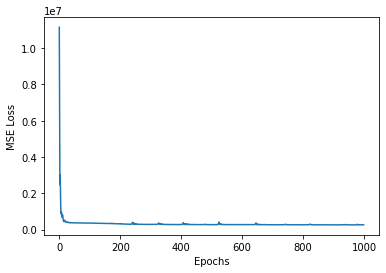

In [444]:
#plot the training loss
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.show()

In [445]:
X.shape

torch.Size([1092, 14, 7])

In [446]:
# make a forecast
def forecast(model, history, n_input):
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, :]
  # print(input_x.shape)
  # reshape into n input arrays
  input_x = torch.tensor(input_x, dtype=torch.float32).view(1, n_input, 7)
  # print(input_x.shape)
  # forecast the next week
  yhat = model.forward(input_x)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat


In [447]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  # calculate an RMSE score for each day
  for i in range(actual.shape[1]):
    # calculate mse
    mse = mean_squared_error(actual[:, i], predicted[:, i])
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
            score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
  return score, scores

In [448]:
# Model Evaluation

# evaluate a single model
def evaluate_model(model, train, test, n_input):
 
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence.tolist())
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = array(predictions)
  # print(predictions)
  score, scores = evaluate_forecasts(test[:, :, 0], predictions)
  return score, scores


In [449]:
test[:, :, 0]

array([[2083.454  , 1604.132  , 2219.78   , 1777.18   , 1769.442  ,
        1797.208  , 2336.9    ],
       [2508.466  , 1518.684  , 2190.558  , 2390.4    , 2514.208  ,
        2196.76   , 2150.112  ],
       [1906.556  , 1881.098  , 2433.508  , 2351.728  , 2137.856  ,
        1790.626  , 2611.502  ],
       [2269.42   , 1930.51   , 2067.564  , 2760.902  , 2110.234  ,
        2092.99   , 2842.728  ],
       [1799.196  , 1693.778  , 2157.432  , 2903.014  , 2316.27   ,
        2098.892  , 2712.986  ],
       [1625.708  , 2582.238  , 2420.932  , 1948.196  , 1369.768  ,
        1892.998  , 2351.556  ],
       [1688.35   , 2097.132  , 1797.756  , 2054.56   , 1761.156  ,
        1953.572  , 1983.728  ],
       [2740.314  , 1474.036  , 1461.28   , 1914.278  , 1880.204  ,
        2120.156  , 1765.056  ],
       [ 711.666  , 1298.728  ,  766.906  ,  935.834  ,  682.88   ,
        1133.726  ,  794.712  ],
       [1372.472  , 2557.098  , 1760.112  , 1822.632  , 1951.09   ,
        1645.424  , 238

cnn: [423.335] 450.7, 431.4, 384.1, 428.7, 397.0, 336.7, 512.9


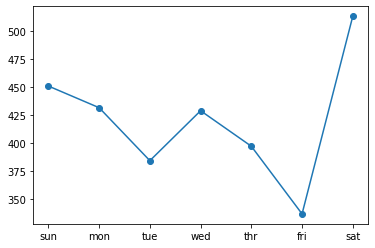

In [450]:

# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(model, train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
plt.plot(days, scores, marker='o', label='cnn') 
plt.show()

In [451]:
!pip install torchviz
!pip install graphviz


     |████████████████████████████████| 47 kB 2.5 MB/s eta 0:00:01
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=1c05e15ebc5054ff55f8177578c9d73a43f218c32b89700c7d04893a440da63d
  Stored in directory: /Users/ajitkumarsingh/Library/Caches/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [453]:
import torch
from torchviz import make_dot

# Assuming 'model' is your PyTorch model and 'train_x_tensor' is your input tensor
# Make a forward pass to get the output
output = model(train_x_tensor)

# Create a dot graph of the model
# You need to provide a sample input tensor (for the shape)
dot = make_dot(output, params=dict(list(model.named_parameters()) + [('train_x_tensor', train_x_tensor)]))

# Save the dot graph to a file (or display it if you are in a Jupyter notebook)
dot.render('model_visualization', format='png')


'model_visualization.png'

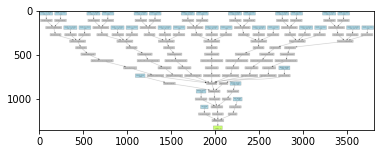

In [458]:
im_read = plt.imread('model_visualization.png')
plt.imshow(im_read)
